This architechture is outdated, but its a good method to try before moving to transformers

In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

import pathlib

# Data

In [3]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [4]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context

In [5]:
target_raw, context_raw = load_data(path_to_file)

English

In [9]:
target_raw[-1]

'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.'

Spanish

In [10]:
context_raw[-1]

'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'

In [12]:
BUFFER_SIZE = len(context_raw)
print(BUFFER_SIZE)
BATCH_SIZE = 64

118964


**is_train** is a non-conventional 80/20 split

In [14]:
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8
is_train

array([ True,  True,  True, ..., False,  True,  True])

In [15]:
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [16]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'\xc3\x89l puso el anillo en el dedo de Mary.'
 b'No nos llame, nosotros lo llamaremos.' b'Sos muy inteligente.'
 b'Pareces estar sufriendo.'
 b'\xc2\xbfQu\xc3\xa9 piensas de este sombrero rojo?'], shape=(5,), dtype=string)

tf.Tensor(
[b"He put the ring on Mary's finger." b"Don't call us, we'll call you."
 b"You're very intelligent." b"You look like you're in pain."
 b'What do you think of this red hat?'], shape=(5,), dtype=string)


## Pre-processing

First, we have to sanitize the strings, removing accents but keeping ponctuation

In [17]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [18]:
example_text = tf.constant('¿Todavía está en casa?')
print(tf_lower_and_split_punct(example_text).numpy().decode())

[START] ¿ todavia esta en casa ? [END]


Now, text vectorization to create the vocabulary

In [28]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))
target_text_processor.adapt(train_raw.map(lambda context, target: target))

In [30]:
print(context_text_processor.get_vocabulary()[:10])
print(target_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']
['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']


Now, using the *example_context_strings* from the *train_raw* we can see the toke id of the words

In [27]:
context_vocab = np.array(context_text_processor.get_vocabulary())

example_tokens = context_text_processor(example_context_strings)
tokens = context_vocab[example_tokens[0].numpy()]
example_text2 = ' '.join(tokens)

print(example_context_strings[0])
print(example_tokens[0])
print(example_text2)

tf.Tensor(b'\xc3\x89l puso el anillo en el dedo de Mary.', shape=(), dtype=string)
tf.Tensor([   2    7  286    7 1899   14    7 1320    6   32    4    3], shape=(12,), dtype=int64)
[START] el puso el anillo en el dedo de mary . [END]


## Preprocessing dataset

Now, we can apply the preprocessing to the whole dataset and return in the format X, Y (but X is different now)

This function converts the dataset to token ids and return 2 targets, *target_in* as X and *target_out* as Y. *target_out* is shifted 1 element ahead of *target_in*, so the model will use the context and present target to guess the next target.

In [1]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor() # Drop the [END] tokens
    targ_out = target[:,1:].to_tensor() # Drop the [START] tokens
    return (context, targ_in), targ_out

In [33]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [35]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[   2    7    9 1470   26 2118    4    3    0    0]

[   2   13   58   38  816  231 1892    4    0    0]
[  13   58   38  816  231 1892    4    3    0    0]


# Attention-based encoder/decoder

Encoder: Left

Decoder: Right

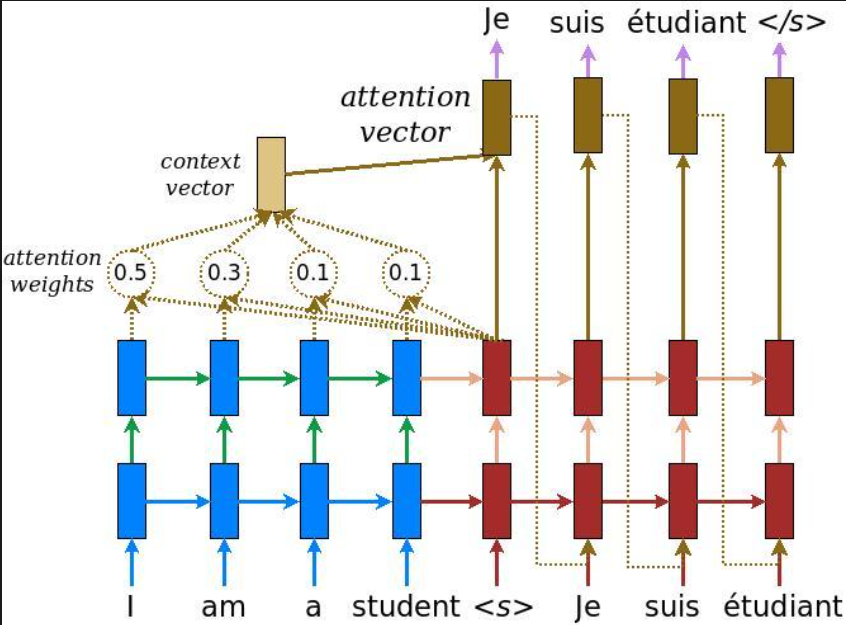

## Encoder

*From Tensorflow:*

The goal of the **encoder** is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep.

The **encoder:**

1. Takes a list of token IDs (from *context_text_processor*).
2. Looks up an embedding vector for each token (Embedding).
3. Processes the embeddings into a new sequence (GRU).
    1. Using bidirectionality to improve performance (processing the input in a left-to-right and a right-to-left fashion).
4. Returns the processed sequence to be passed to the attention head.

In [63]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum', 
            layer=tf.keras.layers.GRU(
                units,
                return_sequences=True, # Return the sequence and state
                recurrent_initializer='glorot_uniform'
            )
        )

    def call(self, x):
        # 1. X is from context_text_processor
        #print(x.shape)
        
        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        #print(x.shape)

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        #print(x.shape)

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [44]:
UNITS = 256
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

(64, 16)
(64, 16, 256)
(64, 16, 256)
Context tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 256)


## Attention head

*From Tensorflow*:

The **attention** layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

In [64]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        #print(x.shape, 'batch t units')
        #print(context.shape, 'batch s units')

        attn_output, attn_scores = self.mha(query=x,value=context,return_attention_scores=True)

        #print(x.shape, 'batch t units')
        #print(attn_scores.shape, 'batch heads t s')

        attn_scores = tf.reduce_mean(attn_scores, axis=1)

        #print(attn_scores.shape, 'batch t s')

        # Cache the attention scores for plotting later.
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [46]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True)

ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

(64, 16, 256) batch t units
(64, 16, 256) batch s units
(64, 16, 256) batch t units
(64, 1, 16, 16) batch heads t s
(64, 16, 16) batch t s


In [47]:
print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 16, 256)
Target sequence, shape (batch, t, units): (64, 16, 256)
Attention result, shape (batch, t, units): (64, 16, 256)
Attention weights, shape (batch, t, s):    (64, 16, 16)


Attention weights

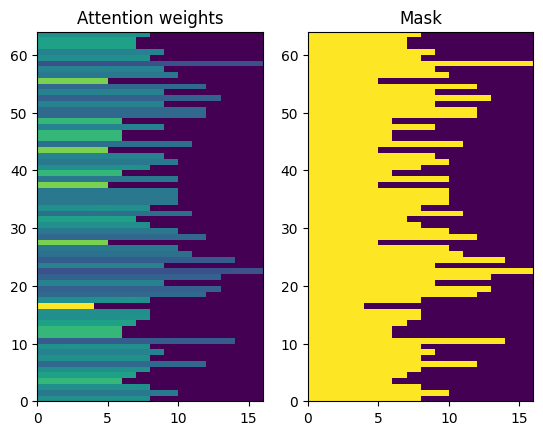

In [51]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

## Decoder

*From Tensorflow:*

The *decoder* job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

The decoder does not use Bidirectionality in the RNN because the information flow is restricted here, only left-to-right, since the model will only produce one word at the time, also, that word should be feed beck into the model.

In [65]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()

        self.text_processor = text_processor
        self.units = units
        self.vocab_size = text_processor.vocabulary_size()

        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]'
        )
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True
        )
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

    @Decoder.add_method
    def call(self, context, x, state=None, return_state=False):  
        #print(x.shape, 'batch t')
        #print(context.shape, 'batch s units')

        # 1. Lookup the embeddings
        x = self.embedding(x)
        #print(x.shape, 'batch t units')

        # 2. Process the target sequence.
        x, state = self.rnn(x, initial_state=state)
        #print(x.shape, 'batch t units')

        # 3. Use the RNN output as the query for the attention over the context.
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights
        #print(x.shape, 'batch t units')
        #print(self.last_attention_weights.shape, 'batch t s')

        # Step 4. Generate logit predictions for the next token.
        logits = self.output_layer(x)
        #print(logits.shape, 'batch t target_vocab_size')

        if return_state:
            return logits, state
        else:
            return logits

In [57]:
decoder = Decoder(target_text_processor, UNITS)
logits = decoder(ex_context, ex_tar_in)

(64, 16) batch t
(64, 16, 256) batch s units
(64, 16, 256) batch t units
(64, 16, 256) batch t units
(64, 16, 256) batch t units
(64, 16, 256) batch s units
(64, 16, 256) batch t units
(64, 1, 16, 16) batch heads t s
(64, 16, 16) batch t s
(64, 16, 256) batch t units
(64, 16, 16) batch t s
(64, 16, 5000) batch t target_vocab_size


To inference we need methods

In [89]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(context, next_token, state = state, return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [66]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    # Run one step.
    next_token, done, state = decoder.get_next_token(ex_context, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

(64, 1, 256) batch t units
(64, 16, 256) batch s units
(64, 1, 256) batch t units
(64, 1, 1, 16) batch heads t s
(64, 1, 16) batch t s
(64, 1, 256) batch t units
(64, 16, 256) batch s units
(64, 1, 256) batch t units
(64, 1, 1, 16) batch heads t s
(64, 1, 16) batch t s
(64, 1, 256) batch t units
(64, 16, 256) batch s units
(64, 1, 256) batch t units
(64, 1, 1, 16) batch heads t s
(64, 1, 16) batch t s
(64, 1, 256) batch t units
(64, 16, 256) batch s units
(64, 1, 256) batch t units
(64, 1, 1, 16) batch heads t s
(64, 1, 16) batch t s
(64, 1, 256) batch t units
(64, 16, 256) batch s units
(64, 1, 256) batch t units
(64, 1, 1, 16) batch heads t s
(64, 1, 16) batch t s
(64, 1, 256) batch t units
(64, 16, 256) batch s units
(64, 1, 256) batch t units
(64, 1, 1, 16) batch heads t s
(64, 1, 16) batch t s
(64, 1, 256) batch t units
(64, 16, 256) batch s units
(64, 1, 256) batch t units
(64, 1, 1, 16) batch heads t s
(64, 1, 16) batch t s
(64, 1, 256) batch t units
(64, 16, 256) batch s units


array([b'bicycle poor tells owls santa hired shape above slices employee',
       b'percent tape chinese tuesday busy cloth waste childrens hes create',
       b'off scratched pool opportunity fruit foreigners hurricane scientist defend sixty'],
      dtype=object)

# Model

Finnaly we can build the model and train it

In [67]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        self.encoder = Encoder(context_text_processor, units)
        self.decoder = Decoder(target_text_processor, units)

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [68]:
model = Translator(UNITS, context_text_processor, target_text_processor)
logits = model((ex_context_tok, ex_tar_in))

In [69]:
print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 16)
logits, shape: (batch, t, target_vocabulary_size) (64, 16, 5000)


# Training

In [70]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [71]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [72]:
model.compile(optimizer='adam', loss=masked_loss, metrics=[masked_acc, masked_loss])

The initial model is random, and shoud give roughly uniform probabilities:

In [73]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(), "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [74]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 125ms/step - loss: 8.5300 - masked_acc: 9.4697e-05 - masked_loss: 8.5300


{'loss': 8.529993057250977,
 'masked_acc': 9.469697397435084e-05,
 'masked_loss': 8.529993057250977}

Yep, its confirmed

Time to fit

In [93]:
model = Translator(UNITS, context_text_processor, target_text_processor)

In [94]:
model.compile(optimizer='adam', loss=masked_loss, metrics=[masked_acc, masked_loss])

In [96]:
%%time
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]
)

Epoch 1/100
100/100 [==============================] - 40s 291ms/step - loss: 5.0302 - masked_acc: 0.2587 - masked_loss: 5.0302 - val_loss: 4.1052 - val_masked_acc: 0.3500 - val_masked_loss: 4.1052
Epoch 2/100
100/100 [==============================] - 28s 277ms/step - loss: 3.7225 - masked_acc: 0.4029 - masked_loss: 3.7225 - val_loss: 3.3974 - val_masked_acc: 0.4349 - val_masked_loss: 3.3974
Epoch 3/100
100/100 [==============================] - 28s 277ms/step - loss: 3.1484 - masked_acc: 0.4726 - masked_loss: 3.1484 - val_loss: 2.8556 - val_masked_acc: 0.5117 - val_masked_loss: 2.8556
Epoch 4/100
100/100 [==============================] - 29s 293ms/step - loss: 2.7517 - masked_acc: 0.5305 - masked_loss: 2.7517 - val_loss: 2.5288 - val_masked_acc: 0.5566 - val_masked_loss: 2.5288
Epoch 5/100
100/100 [==============================] - 29s 288ms/step - loss: 2.4097 - masked_acc: 0.5802 - masked_loss: 2.4097 - val_loss: 2.2859 - val_masked_acc: 0.5888 - val_masked_loss: 2.2859
Epoch 6/10

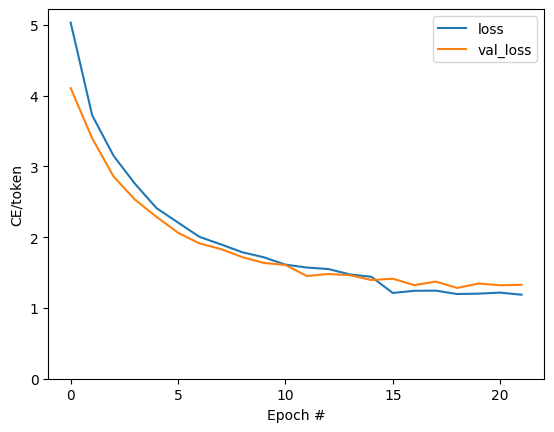

In [97]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

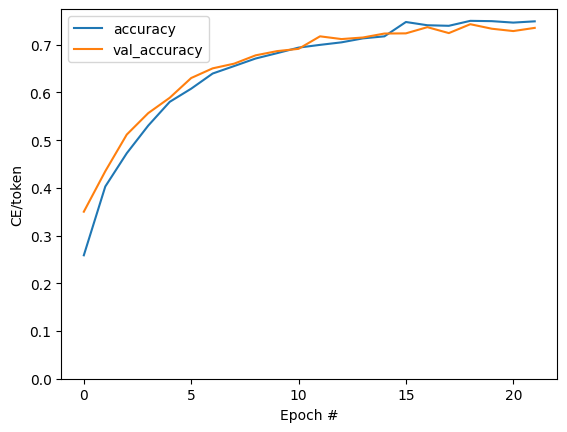

In [98]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Prediction

Lets add a method to make it more reusable

In [83]:
@Translator.add_method
def translate(self, texts, *, max_length=50, temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [100]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy()#.decode()

b'is still home ? '

In [108]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

for t in inputs:
    print(model.translate([t])[0].numpy().decode())

print()

its cold here . 
this is my life . 
her room is a mess . 



Not so good, but its a start

Now, lets see the attention map

In [101]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

C:\Users\joao\AppData\Local\Temp\ipykernel_14040\3440379237.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\joao\AppData\Local\Temp\ipykernel_14040\3440379237.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


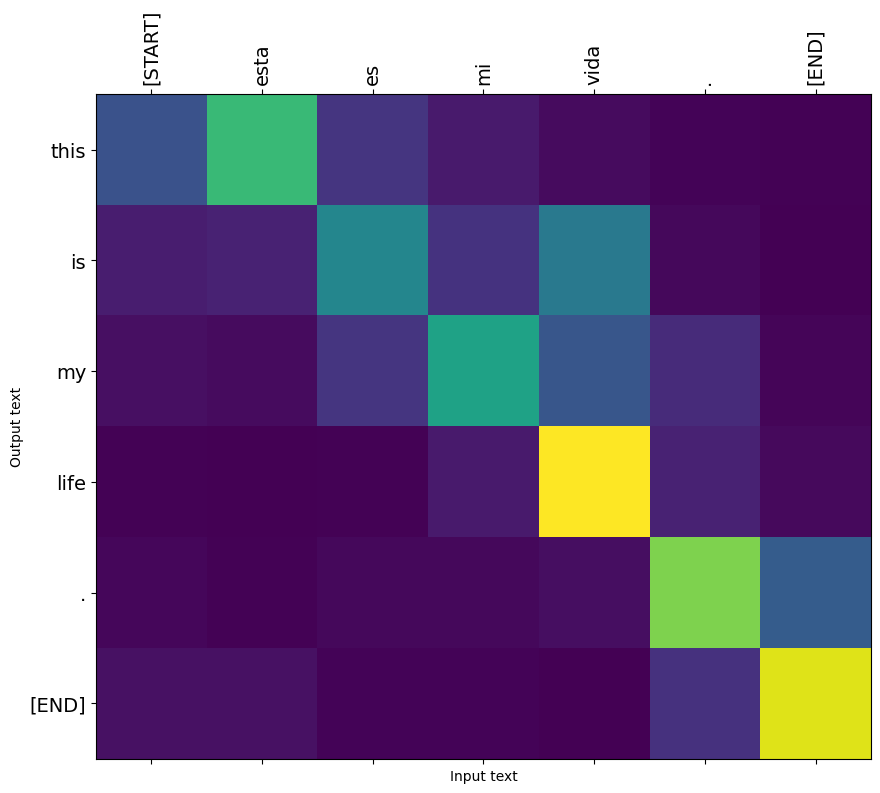

In [103]:
model.plot_attention('Esta es mi vida.') # This is my life.

# Limitations

This approach oly performs with a good metric considering small sentences, when trying bigger pararaphs, the attention loses context, **Transformers** can solve this.

In [104]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


C:\Users\joao\AppData\Local\Temp\ipykernel_14040\3440379237.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\joao\AppData\Local\Temp\ipykernel_14040\3440379237.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


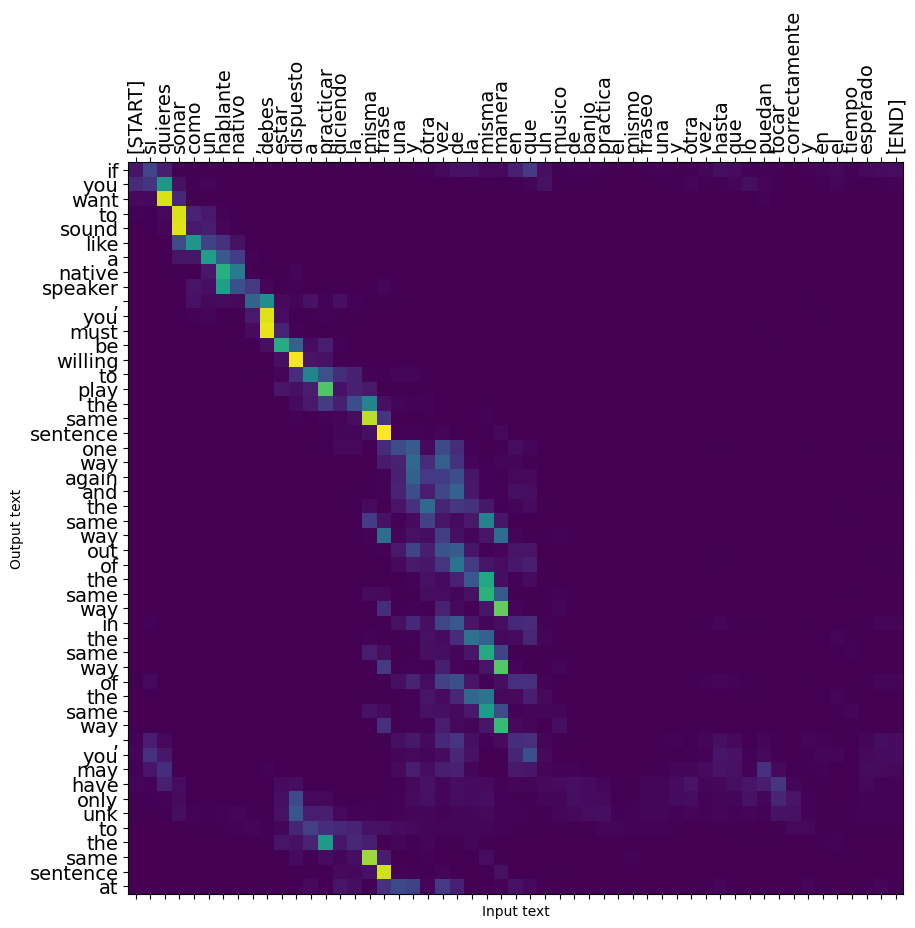

In [107]:
model.plot_attention(long_text)